### Targeting telecon 
2021 Jan 6  
Status update on spectral fitting

In [1]:
import os, pdb
import numpy as np
import pandas as pd
import fitsio
from astropy.table import Table
import matplotlib.ticker as ticker

from desitarget.sv1.sv1_targetmask import desi_mask, bgs_mask, mws_mask

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns
sns.set(context='talk', style='ticks', palette='deep', font_scale=1.3)#, rc=rc)
colors = sns.color_palette()

pref = {'ELG': {'color': colors[0], 'marker': 's'},
        'LRG': {'color': colors[3], 'marker': '^'},
        'BGS_ANY': {'color': colors[8], 'marker': 'o'}}

%matplotlib inline

In [3]:
specprod = 'blanc'
rootdir = os.path.join(os.getenv('DESI_ROOT'), 'ioannis', 'fastspecfit')
datadir = os.path.join(rootdir, specprod, 'tiles')
figdir = os.path.join(os.getenv('HOME'), 'research', 'talks', '20210106-desitarget')

In [4]:
print(desi_mask.names())

['LRG', 'ELG', 'QSO', 'LRG_OPT', 'LRG_IR', 'LRG_SV_OPT', 'LRG_SV_IR', 'LOWZ_FILLER', 'ELG_SV_GTOT', 'ELG_SV_GFIB', 'ELG_FDR_GTOT', 'ELG_FDR_GFIB', 'QSO_COLOR_4PASS', 'QSO_RF_4PASS', 'QSO_COLOR_8PASS', 'QSO_RF_8PASS', 'QSO_HZ_F', 'QSO_Z5', 'LRG_OPT_NORTH', 'LRG_IR_NORTH', 'LRG_SV_OPT_NORTH', 'LRG_SV_IR_NORTH', 'LOWZ_FILLER_NORTH', 'LRG_OPT_SOUTH', 'LRG_IR_SOUTH', 'LRG_SV_OPT_SOUTH', 'LRG_SV_IR_SOUTH', 'LOWZ_FILLER_SOUTH', 'ELG_SV_GTOT_NORTH', 'ELG_SV_GFIB_NORTH', 'ELG_FDR_GTOT_NORTH', 'ELG_FDR_GFIB_NORTH', 'SKY', 'STD_FAINT', 'STD_WD', 'STD_BRIGHT', 'BAD_SKY', 'SUPP_SKY', 'ELG_SV_GTOT_SOUTH', 'ELG_SV_GFIB_SOUTH', 'ELG_FDR_GTOT_SOUTH', 'ELG_FDR_GFIB_SOUTH', 'QSO_COLOR_4PASS_NORTH', 'QSO_RF_4PASS_NORTH', 'QSO_COLOR_8PASS_NORTH', 'QSO_RF_8PASS_NORTH', 'QSO_HZ_F_NORTH', 'QSO_Z5_NORTH', 'QSO_COLOR_4PASS_SOUTH', 'NO_TARGET', 'BRIGHT_OBJECT', 'IN_BRIGHT_OBJECT', 'NEAR_BRIGHT_OBJECT', 'QSO_RF_4PASS_SOUTH', 'QSO_COLOR_8PASS_SOUTH', 'QSO_RF_8PASS_SOUTH', 'QSO_HZ_F_SOUTH', 'QSO_Z5_SOUTH', 'BGS_ANY

In [5]:
expinfo = Table(fitsio.read(os.path.join(rootdir, 'sv1-exposures.fits')))
print(expinfo.colnames)

['NIGHT', 'EXPID', 'TILEID', 'TILERA', 'TILEDEC', 'EXPTIME', 'MJDOBS', 'FIELD', 'TARGETS', 'EBV', 'NGFA', 'B_DEPTH', 'R_DEPTH', 'Z_DEPTH', 'TGT', 'SKY', 'STD', 'WD', 'LRG', 'ELG', 'QSO', 'BGS', 'MWS', 'AIRMASS_MIN', 'AIRMASS_MED', 'AIRMASS_MAX', 'MOON_SEP_DEG_MIN', 'MOON_SEP_DEG_MED', 'MOON_SEP_DEG_MAX', 'TRANSPARENCY_MIN', 'TRANSPARENCY_MED', 'TRANSPARENCY_MAX', 'FWHM_ASEC_MIN', 'FWHM_ASEC_MED', 'FWHM_ASEC_MAX', 'SKY_MAG_AB_MIN', 'SKY_MAG_AB_MED', 'SKY_MAG_AB_MAX', 'FIBER_FRACFLUX_MIN', 'FIBER_FRACFLUX_MED', 'FIBER_FRACFLUX_MAX']


In [6]:
def read_results():
    from glob import glob
    from astropy.table import Column, vstack
    
    specfiles = glob(os.path.join(datadir, 'specfit-806??-202012??.fits'))
    photfiles = glob(os.path.join(datadir, 'photfit-806??-202012??.fits'))
    #specfile = glob(os.path.join(datadir, 'specfit-*.fits'))[0]
    #photfile = glob(os.path.join(datadir, 'photfit-*.fits'))[0]
    print(specfiles)
    spec = vstack([Table(fitsio.read(specfile)) for specfile in specfiles])
    phot = vstack([Table(fitsio.read(photfile)) for photfile in photfiles])
    print('Read {} galaxies from {} specfiles.'.format(len(spec), len(specfiles)))
    print('Read {} galaxies from {} photfiles.'.format(len(phot), len(photfiles)))
    
    ssrt = np.argsort(['{}-{}-{}'.format(night, tile, tid)
                       for night, tile, tid in zip(spec['NIGHT'], spec['TILEID'], spec['TARGETID'])])
    psrt = np.argsort(['{}-{}-{}'.format(night, tile, tid)
                       for night, tile, tid in zip(phot['NIGHT'], phot['TILEID'], phot['TARGETID'])])
    
    phot = phot[psrt]
    spec = spec[ssrt]
    #phot = phot[np.argsort(phot['EXPID'])]
    #spec = spec[np.argsort(spec['EXPID'])]
    assert(np.all(phot['TARGETID'] == spec['TARGETID']))
    
    # Toss out spectrographs 2 and 6.
    petals = spec['FIBER'] // 500
    #print(set(petals))
    keep = np.where(np.logical_not(np.logical_or(petals == 2, petals == 6)))[0]
    #print(len(spec), len(keep))
    spec = spec[keep]
    phot = phot[keep]
    ngal = len(spec)
    print('Removed spectrographs 2 and 6, leaving {} galaxies.'.format(ngal))
    
    # row-match to the conditions file
    expcols = ['TRANSPARENCY_MIN', 'TRANSPARENCY_MAX', 'TRANSPARENCY_MED', 
               'SKY_MAG_AB_MIN', 'SKY_MAG_AB_MAX', 'SKY_MAG_AB_MED', 
               'FWHM_ASEC_MIN', 'FWHM_ASEC_MAX', 'FWHM_ASEC_MED']
    for col in expcols:
        phot.add_column(Column(name=col, length=ngal, dtype=expinfo[col].dtype))
        spec.add_column(Column(name=col, length=ngal, dtype=expinfo[col].dtype))
    
    allexpid = phot['EXPID']
    for expid in set(allexpid):
        I = np.where(expid == allexpid)[0]
        J = np.where(expinfo['EXPID'] == expid)[0]
        #print(I, J)
        for col in expcols:
            phot[col][I] = expinfo[J][col]
            spec[col][I] = expinfo[J][col]
    
    return phot, spec

In [7]:
phot, spec = read_results()

['/Users/ioannis/work/desi/ioannis/fastspecfit/blanc/tiles/specfit-80607-20201214.fits', '/Users/ioannis/work/desi/ioannis/fastspecfit/blanc/tiles/specfit-80608-20201215.fits', '/Users/ioannis/work/desi/ioannis/fastspecfit/blanc/tiles/specfit-80613-20201221.fits']
Read 7251 galaxies from 3 specfiles.
Read 7251 galaxies from 3 photfiles.
Removed spectrographs 2 and 6, leaving 5715 galaxies.


In [8]:
print(phot.colnames)

['TARGETID', 'RA', 'DEC', 'NIGHT', 'TILEID', 'FIBER', 'EXPID', 'Z', 'DELTACHI2', 'PHOTSYS_SOUTH', 'SV1_DESI_TARGET', 'SV1_BGS_TARGET', 'SV1_MWS_TARGET', 'DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET', 'CONTINUUM_PHOT_COEFF', 'CONTINUUM_PHOT_CHI2', 'CONTINUUM_PHOT_AGE', 'CONTINUUM_PHOT_AV', 'CONTINUUM_PHOT_AV_IVAR', 'D4000_MODEL_PHOT', 'FIBERTOTFLUX_G', 'FIBERTOTFLUX_R', 'FIBERTOTFLUX_Z', 'FLUX_G', 'FLUX_IVAR_G', 'FLUX_R', 'FLUX_IVAR_R', 'FLUX_Z', 'FLUX_IVAR_Z', 'FLUX_W1', 'FLUX_IVAR_W1', 'FLUX_W2', 'FLUX_IVAR_W2', 'KCORR_U', 'ABSMAG_U', 'ABSMAG_IVAR_U', 'KCORR_G', 'ABSMAG_G', 'ABSMAG_IVAR_G', 'KCORR_R', 'ABSMAG_R', 'ABSMAG_IVAR_R', 'KCORR_I', 'ABSMAG_I', 'ABSMAG_IVAR_I', 'KCORR_Z', 'ABSMAG_Z', 'ABSMAG_IVAR_Z', 'TRANSPARENCY_MIN', 'TRANSPARENCY_MAX', 'TRANSPARENCY_MED', 'SKY_MAG_AB_MIN', 'SKY_MAG_AB_MAX', 'SKY_MAG_AB_MED', 'FWHM_ASEC_MIN', 'FWHM_ASEC_MAX', 'FWHM_ASEC_MED']


In [9]:
print(spec.colnames)

['TARGETID', 'RA', 'DEC', 'NIGHT', 'TILEID', 'FIBER', 'EXPID', 'Z', 'DELTACHI2', 'PHOTSYS_SOUTH', 'SV1_DESI_TARGET', 'SV1_BGS_TARGET', 'SV1_MWS_TARGET', 'DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET', 'CONTINUUM_SNR', 'CONTINUUM_Z', 'CONTINUUM_COEFF', 'CONTINUUM_CHI2', 'CONTINUUM_AGE', 'CONTINUUM_AV', 'CONTINUUM_AV_IVAR', 'CONTINUUM_VDISP', 'CONTINUUM_VDISP_IVAR', 'D4000', 'D4000_IVAR', 'D4000_MODEL', 'D4000_NOLINES', 'FLUX_SYNTH_G', 'FLUX_SYNTH_R', 'FLUX_SYNTH_Z', 'FLUX_SYNTH_MODEL_G', 'FLUX_SYNTH_MODEL_R', 'FLUX_SYNTH_MODEL_Z', 'LINEVSHIFT_FORBIDDEN', 'LINEVSHIFT_FORBIDDEN_IVAR', 'LINEVSHIFT_BALMER', 'LINEVSHIFT_BALMER_IVAR', 'LINESIGMA_FORBIDDEN', 'LINESIGMA_FORBIDDEN_IVAR', 'LINESIGMA_BALMER', 'LINESIGMA_BALMER_IVAR', 'OII_3726_AMP', 'OII_3726_AMP_IVAR', 'OII_3726_FLUX', 'OII_3726_FLUX_IVAR', 'OII_3726_BOXFLUX', 'OII_3726_BOXFLUX_IVAR', 'OII_3726_CONT', 'OII_3726_CONT_IVAR', 'OII_3726_EW', 'OII_3726_EW_IVAR', 'OII_3726_FLUX_LIMIT', 'OII_3726_EW_LIMIT', 'OII_3726_CHI2', 'OII_3726_NPIX', 

### Sample

BGS_ANY 2005
ELG 2546
LRG 1436
Writing /Users/ioannis/research/talks/20210106-desitarget/zhist.png


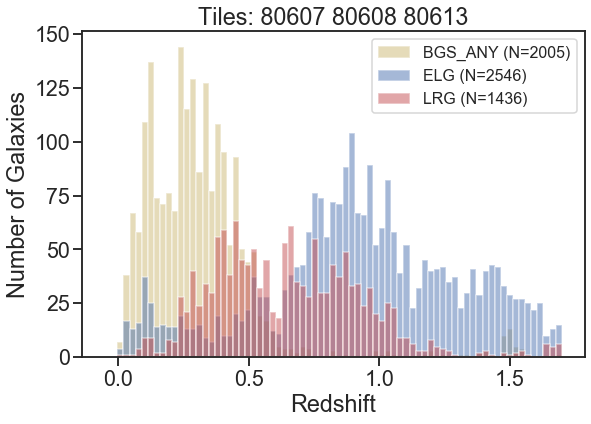

In [10]:
def zhist(png=None):
    fig, ax = plt.subplots(figsize=(9, 6))
    for targ in ['BGS_ANY', 'ELG', 'LRG']:
        itarg = np.where(spec['SV1_DESI_TARGET'] & desi_mask.mask(targ) != 0)[0]
        print(targ, len(itarg))
 
        _ = ax.hist(spec['CONTINUUM_Z'][itarg], label='{} (N={})'.format(targ, len(itarg)), 
                    range=(-0.05, 1.7), bins=75, alpha=0.5,
                    color=pref[targ]['color'])
        ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
        #ax.yaxis.set_major_locator(ticker.MultipleLocator(500))
    
    ax.legend(fontsize=16)
    ax.set_xlabel('Redshift')
    ax.set_ylabel('Number of Galaxies')
    ax.set_title('Tiles: {}'.format(' '.join(sorted(set(spec['TILEID'].astype(str))))))
    
    if png:
        print('Writing {}'.format(png))
        fig.savefig(png)
        
zhist(png=os.path.join(figdir, 'zhist.png'))

In [11]:
#itarg = np.where(spec['SV1_DESI_TARGET'] & desi_mask.mask('ELG') != 0)[0]
#_ = plt.hist(22.5-2.5*np.log10(phot['FIBERTOTFLUX_G'][itarg]), bins=100, range=(22, 25))
#_ = plt.hist(22.5-2.5*np.log10(phot['FIBERTOTFLUX_R'][itarg]), bins=100, alpha=0.5, range=(22, 25))

Writing /Users/ioannis/research/talks/20210106-desitarget/snr.png


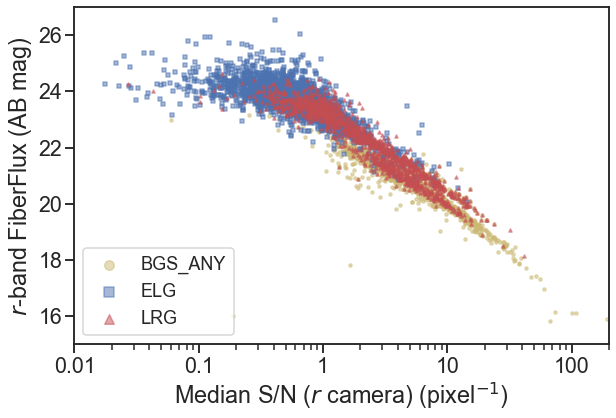

In [12]:
def snr(png=None):
    fig, ax = plt.subplots(figsize=(9, 6))
    for targ in ['BGS_ANY', 'ELG', 'LRG']:
        itarg = np.where(spec['SV1_DESI_TARGET'] & desi_mask.mask(targ) != 0)[0]
        ax.scatter(spec['CONTINUUM_SNR'][itarg, 1], 22.5-2.5*np.log10(phot['FIBERTOTFLUX_R'][itarg]), 
                   s=10, marker=pref[targ]['marker'], alpha=0.5, label=targ,
                   color=pref[targ]['color'])
    ax.set_xscale('log')
    ax.set_xlim(0.01, 200)
    ax.set_ylim(15, 27)
    ax.set_xlabel(r'Median S/N ($r$ camera) (pixel$^{-1}$)')
    ax.set_ylabel('$r$-band FiberFlux (AB mag)')
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    ax.legend(loc='lower left', markerscale=3, fontsize=18)    
    
    fig.subplots_adjust(bottom=0.17, right=0.95, top=0.95)
    
    if png:
        print('Writing {}'.format(png))
        fig.savefig(png)
        
snr(png=os.path.join(figdir, 'snr.png'))

In [13]:
these = np.where((spec['SV1_DESI_TARGET'] & desi_mask.mask('LRG') != 0) * 
                 (spec['CONTINUUM_SNR'][:, 1] > 10) * 
                 (spec['Z'] > 0.6))[0]
spec[these]

TARGETID,RA,DEC,NIGHT,TILEID,FIBER,EXPID,Z,DELTACHI2,PHOTSYS_SOUTH,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,CONTINUUM_SNR [3],CONTINUUM_Z,CONTINUUM_COEFF [11],CONTINUUM_CHI2,CONTINUUM_AGE,CONTINUUM_AV,CONTINUUM_AV_IVAR,CONTINUUM_VDISP,CONTINUUM_VDISP_IVAR,D4000,D4000_IVAR,D4000_MODEL,D4000_NOLINES,FLUX_SYNTH_G,FLUX_SYNTH_R,FLUX_SYNTH_Z,FLUX_SYNTH_MODEL_G,FLUX_SYNTH_MODEL_R,FLUX_SYNTH_MODEL_Z,LINEVSHIFT_FORBIDDEN,LINEVSHIFT_FORBIDDEN_IVAR,LINEVSHIFT_BALMER,LINEVSHIFT_BALMER_IVAR,LINESIGMA_FORBIDDEN,LINESIGMA_FORBIDDEN_IVAR,LINESIGMA_BALMER,LINESIGMA_BALMER_IVAR,OII_3726_AMP,OII_3726_AMP_IVAR,OII_3726_FLUX,OII_3726_FLUX_IVAR,OII_3726_BOXFLUX,OII_3726_BOXFLUX_IVAR,OII_3726_CONT,OII_3726_CONT_IVAR,OII_3726_EW,OII_3726_EW_IVAR,OII_3726_FLUX_LIMIT,OII_3726_EW_LIMIT,OII_3726_CHI2,OII_3726_NPIX,OII_3729_AMP,OII_3729_AMP_IVAR,OII_3729_FLUX,OII_3729_FLUX_IVAR,OII_3729_BOXFLUX,OII_3729_BOXFLUX_IVAR,OII_3729_CONT,OII_3729_CONT_IVAR,OII_3729_EW,OII_3729_EW_IVAR,OII_3729_FLUX_LIMIT,OII_3729_EW_LIMIT,OII_3729_CHI2,OII_3729_NPIX,OIII_4959_AMP,OIII_4959_AMP_IVAR,OIII_4959_FLUX,OIII_4959_FLUX_IVAR,OIII_4959_BOXFLUX,OIII_4959_BOXFLUX_IVAR,OIII_4959_CONT,OIII_4959_CONT_IVAR,OIII_4959_EW,OIII_4959_EW_IVAR,OIII_4959_FLUX_LIMIT,OIII_4959_EW_LIMIT,OIII_4959_CHI2,OIII_4959_NPIX,OIII_5007_AMP,OIII_5007_AMP_IVAR,OIII_5007_FLUX,OIII_5007_FLUX_IVAR,OIII_5007_BOXFLUX,OIII_5007_BOXFLUX_IVAR,OIII_5007_CONT,OIII_5007_CONT_IVAR,OIII_5007_EW,OIII_5007_EW_IVAR,OIII_5007_FLUX_LIMIT,OIII_5007_EW_LIMIT,OIII_5007_CHI2,OIII_5007_NPIX,NII_6548_AMP,NII_6548_AMP_IVAR,NII_6548_FLUX,NII_6548_FLUX_IVAR,NII_6548_BOXFLUX,NII_6548_BOXFLUX_IVAR,NII_6548_CONT,NII_6548_CONT_IVAR,NII_6548_EW,NII_6548_EW_IVAR,NII_6548_FLUX_LIMIT,NII_6548_EW_LIMIT,NII_6548_CHI2,NII_6548_NPIX,NII_6584_AMP,NII_6584_AMP_IVAR,NII_6584_FLUX,NII_6584_FLUX_IVAR,NII_6584_BOXFLUX,NII_6584_BOXFLUX_IVAR,NII_6584_CONT,NII_6584_CONT_IVAR,NII_6584_EW,NII_6584_EW_IVAR,NII_6584_FLUX_LIMIT,NII_6584_EW_LIMIT,NII_6584_CHI2,NII_6584_NPIX,SII_6716_AMP,SII_6716_AMP_IVAR,SII_6716_FLUX,SII_6716_FLUX_IVAR,SII_6716_BOXFLUX,SII_6716_BOXFLUX_IVAR,SII_6716_CONT,SII_6716_CONT_IVAR,SII_6716_EW,SII_6716_EW_IVAR,SII_6716_FLUX_LIMIT,SII_6716_EW_LIMIT,SII_6716_CHI2,SII_6716_NPIX,SII_6731_AMP,SII_6731_AMP_IVAR,SII_6731_FLUX,SII_6731_FLUX_IVAR,SII_6731_BOXFLUX,SII_6731_BOXFLUX_IVAR,SII_6731_CONT,SII_6731_CONT_IVAR,SII_6731_EW,SII_6731_EW_IVAR,SII_6731_FLUX_LIMIT,SII_6731_EW_LIMIT,SII_6731_CHI2,SII_6731_NPIX,HEPSILON_AMP,HEPSILON_AMP_IVAR,HEPSILON_FLUX,HEPSILON_FLUX_IVAR,HEPSILON_BOXFLUX,HEPSILON_BOXFLUX_IVAR,HEPSILON_CONT,HEPSILON_CONT_IVAR,HEPSILON_EW,HEPSILON_EW_IVAR,HEPSILON_FLUX_LIMIT,HEPSILON_EW_LIMIT,HEPSILON_CHI2,HEPSILON_NPIX,HDELTA_AMP,HDELTA_AMP_IVAR,HDELTA_FLUX,HDELTA_FLUX_IVAR,HDELTA_BOXFLUX,HDELTA_BOXFLUX_IVAR,HDELTA_CONT,HDELTA_CONT_IVAR,HDELTA_EW,HDELTA_EW_IVAR,HDELTA_FLUX_LIMIT,HDELTA_EW_LIMIT,HDELTA_CHI2,HDELTA_NPIX,HGAMMA_AMP,HGAMMA_AMP_IVAR,HGAMMA_FLUX,HGAMMA_FLUX_IVAR,HGAMMA_BOXFLUX,HGAMMA_BOXFLUX_IVAR,HGAMMA_CONT,HGAMMA_CONT_IVAR,HGAMMA_EW,HGAMMA_EW_IVAR,HGAMMA_FLUX_LIMIT,HGAMMA_EW_LIMIT,HGAMMA_CHI2,HGAMMA_NPIX,HBETA_AMP,HBETA_AMP_IVAR,HBETA_FLUX,HBETA_FLUX_IVAR,HBETA_BOXFLUX,HBETA_BOXFLUX_IVAR,HBETA_CONT,HBETA_CONT_IVAR,HBETA_EW,HBETA_EW_IVAR,HBETA_FLUX_LIMIT,HBETA_EW_LIMIT,HBETA_CHI2,HBETA_NPIX,HALPHA_AMP,HALPHA_AMP_IVAR,HALPHA_FLUX,HALPHA_FLUX_IVAR,HALPHA_BOXFLUX,HALPHA_BOXFLUX_IVAR,HALPHA_CONT,HALPHA_CONT_IVAR,HALPHA_EW,HALPHA_EW_IVAR,HALPHA_FLUX_LIMIT,HALPHA_EW_LIMIT,HALPHA_CHI2,HALPHA_NPIX,TRANSPARENCY_MIN,TRANSPARENCY_MAX,TRANSPARENCY_MED,SKY_MAG_AB_MIN,SKY_MAG_AB_MAX,SKY_MAG_AB_MED,FWHM_ASEC_MIN,FWHM_ASEC_MAX,FWHM_ASEC_MED
int64,float64,float64,int32,int32,int32,int32,float64,float64,bool,int64,int64,int64,int64,int64,int64,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,

### ELG Targets

Number of ELGs=2546
Number with one [OII] line=247
Number with both [OII] lines=2214
Number with neither line=85
Writing /Users/ioannis/research/talks/20210106-desitarget/oiiflux-vs-redshift.png


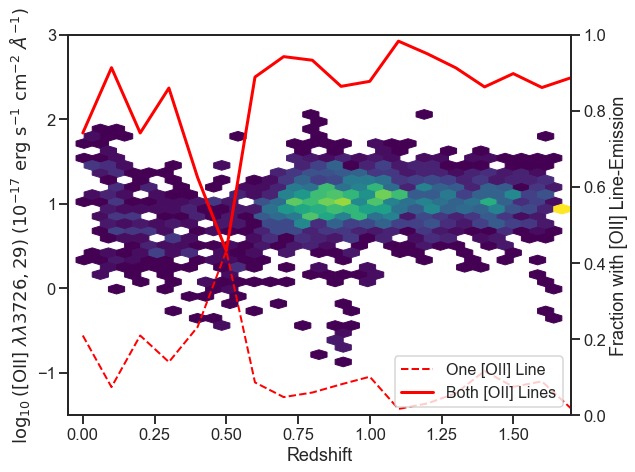

In [14]:
def zhist_bins(deltaz=0.1, zmin=0.0, zmax=2, target='ELG', binedges=False):
    if target.strip() == 'LRG':
        zmin, zmax = 0.0, 1.2
    elif target.strip() == 'BGS':
        zmin, zmax = 0.0, 0.5
    else:
        pass
    if binedges:
        bins = np.arange(zmin, zmax, deltaz) # bin left edges
    else:
        bins = np.arange(zmin, zmax, deltaz) + deltaz / 2 # bin centers
    return bins

def zhist_type(data, target='ELG'):
    bins = zhist_bins(target=target, binedges=True)
    hist, _ = np.histogram( data, bins=len(bins), range=(bins.min(), bins.max()) )
    return hist, bins

def elg_oiiflux(png=None):

    ielg = np.where(spec['SV1_DESI_TARGET'] & desi_mask.mask('ELG') != 0)[0]
    oii_blue = np.where(((spec['SV1_DESI_TARGET'] & desi_mask.mask('ELG') != 0) * 
                        (spec['OII_3726_FLUX'] > 0) * (spec['OII_3729_FLUX'] <= 0)))[0]
    oii_red = np.where(((spec['SV1_DESI_TARGET'] & desi_mask.mask('ELG') != 0) * 
                        (spec['OII_3726_FLUX'] <= 0) * (spec['OII_3729_FLUX'] > 0)))[0]
    oii_both = np.where((spec['SV1_DESI_TARGET'] & desi_mask.mask('ELG') != 0) * 
                        (spec['OII_3726_FLUX'] > 0) * (spec['OII_3729_FLUX'] > 0))[0]
    print('Number of ELGs={}'.format(len(ielg)))
    print('Number with one [OII] line={}'.format(len(oii_blue)+len(oii_red)))
    print('Number with both [OII] lines={}'.format(len(oii_both)))
    print('Number with neither line={}'.format(len(ielg)-(len(oii_both)+len(oii_blue)+len(oii_red))))
    #print(np.median(spec['OII_3726_FLUX'][oii_both]*np.sqrt(spec['OII_3726_FLUX_IVAR'][oii_both])))

    #oii = np.zeros(np.sum(itarg))
    oii = spec['OII_3726_FLUX'][oii_both] + spec['OII_3729_FLUX'][oii_both]
    oiiblue = spec['OII_3726_FLUX'][oii_blue] * (1+1/0.73)
    oiired = spec['OII_3729_FLUX'][oii_red] * (1+0.73)
    
    #print(spec[oii_both]['TARGETID', 'TILEID', 'NIGHT', 'OII_3726_FLUX', 'OII_3729_FLUX'])
    
    with sns.plotting_context(context='talk', font_scale=1.0):    
        fig, ax = plt.subplots(figsize=(9, 7))
        ax.hexbin(spec['Z'][oii_both], np.log10(oii), mincnt=1, gridsize=30,
                  cmap='viridis')
        #ax.scatter(spec['Z'][oii_red], np.log10(oiired), s=100, 
        #           color='red', marker='s')
        #ax.scatter(spec['Z'][oii_blue], np.log10(oiiblue), s=100, 
        #           color='blue', marker='s')
        
        #plt.axvline(x=5577/3727-1, color='k')
        #plt.axvline(x=4440/3727-1, color='k')
        #plt.axvline(x=0.893, color='k')

        ax.set_xlim(-0.05, 1.7)
        ax.set_ylim(-1.5, 3.0)
        #ax.axhline(y=-1, ls='--', color='gray')
        ax.set_xlabel('Redshift')
        ax.set_ylabel('$\log_{10}\,(\mathrm{[O II]}\ \lambda\lambda3726,29)$ $(10^{-17}~\mathrm{erg}~\mathrm{s}^{-1}~\mathrm{cm}^{-2}~\AA^{-1})$')
        #ax.set_title('Tile 80608\newline (ELG/Lynx)')
        
        elghist, elgzbins = zhist_type(spec['Z'][ielg])
        oiibothhist, _ = zhist_type(spec['Z'][oii_both])
        #oiiredhist, _ = zhist_type(spec['Z'][oii_red])
        #oiibluehist, _ = zhist_type(spec['Z'][oii_blue])
        oiiblueredhist, _ = zhist_type(spec['Z'][np.hstack((oii_red,oii_blue))])
        
        zgood = np.where(elghist > 0)[0]
        
        axtwin = ax.twinx()
        axtwin.plot(elgzbins[zgood], oiiblueredhist[zgood]/elghist[zgood], 
                    color='red', ls='--', lw=2, label='One [OII] Line')
        axtwin.plot(elgzbins[zgood], oiibothhist[zgood]/elghist[zgood], 
                    color='red', ls='-', lw=3, label='Both [OII] Lines')
                    #label=r'[OII] $\lambda3726>0$, [OII] $\lambda3729>0$')
                                       
        #axtwin.plot(elgzbins[zgood], oiiredhist[zgood]/elghist[zgood], 
        #            color='red', ls='--', lw=2, label=r'[OII] $\lambda3726>0$')
        #axtwin.plot(elgzbins[zgood], oiibluehist[zgood]/elghist[zgood], 
        #            color='blue', ls='--', lw=2, label=r'[OII] $\lambda3729>0$')
        axtwin.set_ylim(0, 1)
        axtwin.set_ylabel('Fraction with [OII] Line-Emission')
        axtwin.legend(loc='lower right', fontsize=16)
        
    #fig.subplots_adjust(left=0.15)
    if png:
        print('Writing {}'.format(png))
        fig.savefig(png)
        
elg_oiiflux(png=os.path.join(figdir, 'oiiflux-vs-redshift.png'))

In [15]:
itarg = np.where((spec['SV1_DESI_TARGET'] & desi_mask.mask('LRG') != 0) * 
                 (spec['TILEID'] == 80607))[0]
spec[itarg]

TARGETID,RA,DEC,NIGHT,TILEID,FIBER,EXPID,Z,DELTACHI2,PHOTSYS_SOUTH,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,CONTINUUM_SNR [3],CONTINUUM_Z,CONTINUUM_COEFF [11],CONTINUUM_CHI2,CONTINUUM_AGE,CONTINUUM_AV,CONTINUUM_AV_IVAR,CONTINUUM_VDISP,CONTINUUM_VDISP_IVAR,D4000,D4000_IVAR,D4000_MODEL,D4000_NOLINES,FLUX_SYNTH_G,FLUX_SYNTH_R,FLUX_SYNTH_Z,FLUX_SYNTH_MODEL_G,FLUX_SYNTH_MODEL_R,FLUX_SYNTH_MODEL_Z,LINEVSHIFT_FORBIDDEN,LINEVSHIFT_FORBIDDEN_IVAR,LINEVSHIFT_BALMER,LINEVSHIFT_BALMER_IVAR,LINESIGMA_FORBIDDEN,LINESIGMA_FORBIDDEN_IVAR,LINESIGMA_BALMER,LINESIGMA_BALMER_IVAR,OII_3726_AMP,OII_3726_AMP_IVAR,OII_3726_FLUX,OII_3726_FLUX_IVAR,OII_3726_BOXFLUX,OII_3726_BOXFLUX_IVAR,OII_3726_CONT,OII_3726_CONT_IVAR,OII_3726_EW,OII_3726_EW_IVAR,OII_3726_FLUX_LIMIT,OII_3726_EW_LIMIT,OII_3726_CHI2,OII_3726_NPIX,OII_3729_AMP,OII_3729_AMP_IVAR,OII_3729_FLUX,OII_3729_FLUX_IVAR,OII_3729_BOXFLUX,OII_3729_BOXFLUX_IVAR,OII_3729_CONT,OII_3729_CONT_IVAR,OII_3729_EW,OII_3729_EW_IVAR,OII_3729_FLUX_LIMIT,OII_3729_EW_LIMIT,OII_3729_CHI2,OII_3729_NPIX,OIII_4959_AMP,OIII_4959_AMP_IVAR,OIII_4959_FLUX,OIII_4959_FLUX_IVAR,OIII_4959_BOXFLUX,OIII_4959_BOXFLUX_IVAR,OIII_4959_CONT,OIII_4959_CONT_IVAR,OIII_4959_EW,OIII_4959_EW_IVAR,OIII_4959_FLUX_LIMIT,OIII_4959_EW_LIMIT,OIII_4959_CHI2,OIII_4959_NPIX,OIII_5007_AMP,OIII_5007_AMP_IVAR,OIII_5007_FLUX,OIII_5007_FLUX_IVAR,OIII_5007_BOXFLUX,OIII_5007_BOXFLUX_IVAR,OIII_5007_CONT,OIII_5007_CONT_IVAR,OIII_5007_EW,OIII_5007_EW_IVAR,OIII_5007_FLUX_LIMIT,OIII_5007_EW_LIMIT,OIII_5007_CHI2,OIII_5007_NPIX,NII_6548_AMP,NII_6548_AMP_IVAR,NII_6548_FLUX,NII_6548_FLUX_IVAR,NII_6548_BOXFLUX,NII_6548_BOXFLUX_IVAR,NII_6548_CONT,NII_6548_CONT_IVAR,NII_6548_EW,NII_6548_EW_IVAR,NII_6548_FLUX_LIMIT,NII_6548_EW_LIMIT,NII_6548_CHI2,NII_6548_NPIX,NII_6584_AMP,NII_6584_AMP_IVAR,NII_6584_FLUX,NII_6584_FLUX_IVAR,NII_6584_BOXFLUX,NII_6584_BOXFLUX_IVAR,NII_6584_CONT,NII_6584_CONT_IVAR,NII_6584_EW,NII_6584_EW_IVAR,NII_6584_FLUX_LIMIT,NII_6584_EW_LIMIT,NII_6584_CHI2,NII_6584_NPIX,SII_6716_AMP,SII_6716_AMP_IVAR,SII_6716_FLUX,SII_6716_FLUX_IVAR,SII_6716_BOXFLUX,SII_6716_BOXFLUX_IVAR,SII_6716_CONT,SII_6716_CONT_IVAR,SII_6716_EW,SII_6716_EW_IVAR,SII_6716_FLUX_LIMIT,SII_6716_EW_LIMIT,SII_6716_CHI2,SII_6716_NPIX,SII_6731_AMP,SII_6731_AMP_IVAR,SII_6731_FLUX,SII_6731_FLUX_IVAR,SII_6731_BOXFLUX,SII_6731_BOXFLUX_IVAR,SII_6731_CONT,SII_6731_CONT_IVAR,SII_6731_EW,SII_6731_EW_IVAR,SII_6731_FLUX_LIMIT,SII_6731_EW_LIMIT,SII_6731_CHI2,SII_6731_NPIX,HEPSILON_AMP,HEPSILON_AMP_IVAR,HEPSILON_FLUX,HEPSILON_FLUX_IVAR,HEPSILON_BOXFLUX,HEPSILON_BOXFLUX_IVAR,HEPSILON_CONT,HEPSILON_CONT_IVAR,HEPSILON_EW,HEPSILON_EW_IVAR,HEPSILON_FLUX_LIMIT,HEPSILON_EW_LIMIT,HEPSILON_CHI2,HEPSILON_NPIX,HDELTA_AMP,HDELTA_AMP_IVAR,HDELTA_FLUX,HDELTA_FLUX_IVAR,HDELTA_BOXFLUX,HDELTA_BOXFLUX_IVAR,HDELTA_CONT,HDELTA_CONT_IVAR,HDELTA_EW,HDELTA_EW_IVAR,HDELTA_FLUX_LIMIT,HDELTA_EW_LIMIT,HDELTA_CHI2,HDELTA_NPIX,HGAMMA_AMP,HGAMMA_AMP_IVAR,HGAMMA_FLUX,HGAMMA_FLUX_IVAR,HGAMMA_BOXFLUX,HGAMMA_BOXFLUX_IVAR,HGAMMA_CONT,HGAMMA_CONT_IVAR,HGAMMA_EW,HGAMMA_EW_IVAR,HGAMMA_FLUX_LIMIT,HGAMMA_EW_LIMIT,HGAMMA_CHI2,HGAMMA_NPIX,HBETA_AMP,HBETA_AMP_IVAR,HBETA_FLUX,HBETA_FLUX_IVAR,HBETA_BOXFLUX,HBETA_BOXFLUX_IVAR,HBETA_CONT,HBETA_CONT_IVAR,HBETA_EW,HBETA_EW_IVAR,HBETA_FLUX_LIMIT,HBETA_EW_LIMIT,HBETA_CHI2,HBETA_NPIX,HALPHA_AMP,HALPHA_AMP_IVAR,HALPHA_FLUX,HALPHA_FLUX_IVAR,HALPHA_BOXFLUX,HALPHA_BOXFLUX_IVAR,HALPHA_CONT,HALPHA_CONT_IVAR,HALPHA_EW,HALPHA_EW_IVAR,HALPHA_FLUX_LIMIT,HALPHA_EW_LIMIT,HALPHA_CHI2,HALPHA_NPIX,TRANSPARENCY_MIN,TRANSPARENCY_MAX,TRANSPARENCY_MED,SKY_MAG_AB_MIN,SKY_MAG_AB_MAX,SKY_MAG_AB_MED,FWHM_ASEC_MIN,FWHM_ASEC_MAX,FWHM_ASEC_MED
int64,float64,float64,int32,int32,int32,int32,float64,float64,bool,int64,int64,int64,int64,int64,int64,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,

In [16]:
def restphot(targ='ELG', png=None):
    """
    fastspecfit-qa --photfitfile /global/cfs/cdirs/desi/users/ioannis/fastspecfit/blanc/tiles/photfit-80607-20201214.fits --specfitfile /global/cfs/cdirs/desi/users/ioannis/fastspecfit/blanc/tiles/specfit-80607-20201214.fits --outdir tmp/lrg --night 20201214 --tile 80607 --mp 32 --targetids 39633317678548005,39633317678549957,39633331544917404,39633321159819482
    
    """
    itarg = np.where(spec['SV1_DESI_TARGET'] & desi_mask.mask(targ) != 0)[0]

    if targ == 'ELG':
        absmaglim = (-10, -26)
        grlim = (-0.6, 1.1)
        ss = 5
        label = 'All {}s'.format(targ)
    elif targ == 'LRG':
        absmaglim = (-19, -26)
        grlim = (0.1, 1.1)
        ss = 10
        label = 'All {}s'.format(targ)
    else:
        absmaglim = (-15, -27)
        grlim = (-0.6, 1.1)
        ss = 10
        label = 'All BGS'
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.scatter(phot['Z'][itarg], phot['ABSMAG_R'][itarg], s=ss, 
                color=pref[targ]['color'], marker=pref[targ]['marker'],
                alpha=0.7, label=label)
    #ax.set_xlim(0.01, 200)
    ax1.set_ylim(absmaglim)
    ax1.set_xlabel('Redshift')
    ax1.set_ylabel(r'M$_{0.0_{r}}$')
    #ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    
    ax2.scatter(phot['ABSMAG_R'][itarg], phot['ABSMAG_G'][itarg]-phot['ABSMAG_R'][itarg],
                s=ss, color=pref[targ]['color'], marker=pref[targ]['marker'],
                alpha=0.7)
    ax2.set_xlim(absmaglim)
    ax2.set_ylim(grlim)
    ax2.set_ylabel(r'$^{0.0}(g - r)$')
    ax2.set_xlabel(r'M$_{0.0_{r}}$')
    
    if targ == 'ELG':
        cut = np.where((phot['ABSMAG_R'][itarg] < -16) *
                       (phot['ABSMAG_R'][itarg] > -21) *
                       (phot['ABSMAG_G'][itarg]-phot['ABSMAG_R'][itarg] < -0.35) *
                       (phot['ABSMAG_G'][itarg]-phot['ABSMAG_R'][itarg] > -0.5))[0]
        print(len(cut))
        print(spec['NIGHT', 'TILEID', 'TARGETID', 'Z'][itarg][cut][:10])
        ax1.scatter(phot['Z'][itarg][cut], phot['ABSMAG_R'][itarg][cut], s=ss, 
                    color='red', marker=pref[targ]['marker'], alpha=0.7,
                    label='Suspicious Colors')
        ax2.scatter(phot['ABSMAG_R'][itarg][cut], phot['ABSMAG_G'][itarg][cut]-phot['ABSMAG_R'][itarg][cut],
                    s=ss, color='red', marker=pref[targ]['marker'], alpha=0.7)
        
    if targ == 'BGS_ANY':
        cut = np.where((phot['Z'][itarg] > 0.75))[0]
        print(len(cut))
        print(spec['NIGHT', 'TILEID', 'TARGETID', 'Z'][itarg][cut][:10])
        ax1.scatter(phot['Z'][itarg][cut], phot['ABSMAG_R'][itarg][cut], s=ss, 
                    color='green', marker=pref[targ]['marker'], alpha=0.7,
                    label=r'$z>0.75$')
        ax2.scatter(phot['ABSMAG_R'][itarg][cut], phot['ABSMAG_G'][itarg][cut]-phot['ABSMAG_R'][itarg][cut],
                    s=ss, color='green', marker=pref[targ]['marker'], alpha=0.7)

    if targ == 'LRG':
        cut = np.where((phot['Z'][itarg] > 1.58))[0]
        print(len(cut))
        print(spec['NIGHT', 'TILEID', 'TARGETID', 'Z'][itarg][cut][:10])
        ax1.scatter(phot['Z'][itarg][cut], phot['ABSMAG_R'][itarg][cut], s=ss, 
                    color='blue', marker=pref[targ]['marker'], alpha=0.7,
                    label='z~1.6 pile-up')
        ax2.scatter(phot['ABSMAG_R'][itarg][cut], phot['ABSMAG_G'][itarg][cut]-phot['ABSMAG_R'][itarg][cut],
                    s=ss, color='blue', marker=pref[targ]['marker'], alpha=0.7)
        
    ax1.legend(loc='lower right', markerscale=3, fontsize=16)    
        
    fig.subplots_adjust(wspace=0.3, bottom=0.2, left=0.1, right=0.95, top=0.95)
    
    if png:
        print('Writing {}'.format(png))
        fig.savefig(png)

53
 NIGHT   TILEID      TARGETID             Z         
-------- ------ ----------------- ------------------
20201214  80607 39633317670162883 1.1848119423990224
20201214  80607 39633321168209874 1.5457146175626975
20201214  80607 39633345008633919 0.8921823559309874
20201214  80607 39633345008633930 1.0872822246472666
20201215  80608 39633317670162173 1.5050422998554551
20201215  80608 39633317678549229 1.4990379736437076
20201215  80608 39633317678550008 0.9743344675237244
20201215  80608 39633321172402225 0.5095141632866157
20201215  80608 39633321176600198 1.0316240856322991
20201215  80608 39633324624317316 0.8208049979807531
Writing /Users/ioannis/research/talks/20210106-desitarget/elg-restphot.png


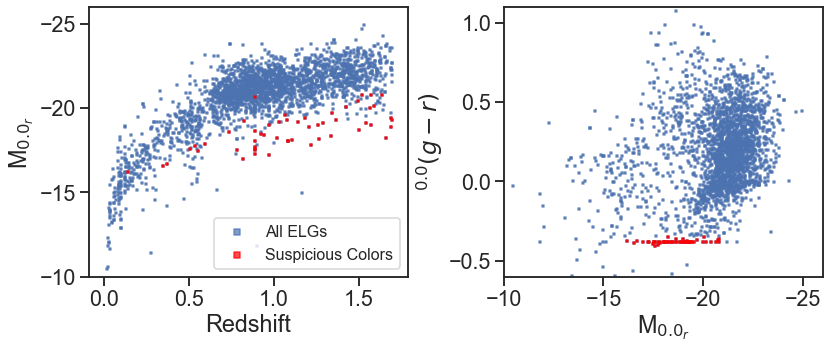

In [17]:
restphot(targ='ELG', png=os.path.join(figdir, 'elg-restphot.png'))    

### LRGs

17
 NIGHT   TILEID      TARGETID             Z         
-------- ------ ----------------- ------------------
20201214  80607 39633317678548005  1.655409115775544
20201214  80607 39633317678549957 1.6397546047886338
20201214  80607 39633317686936204 1.6771636488650328
20201214  80607 39633321151433703 1.6424108408378537
20201214  80607 39633321159819482 1.6401910943792286
20201214  80607 39633324649481643 1.6883241784820302
20201214  80607 39633331523947433  1.680155980900851
20201214  80607 39633331544917404  1.644799759994023
20201214  80607 39633334938109859 1.6841739234127993
20201214  80607 39633338306134168 1.6873971426784558
Writing /Users/ioannis/research/talks/20210106-desitarget/lrg-restphot.png


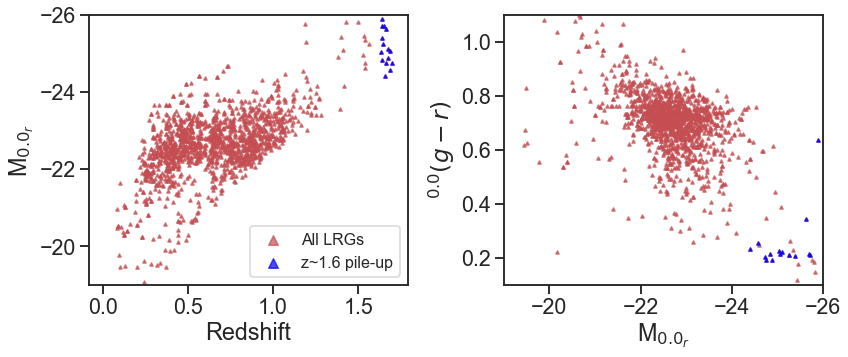

In [18]:
restphot(targ='LRG', png=os.path.join(figdir, 'lrg-restphot.png'))    

### BGS

59
 NIGHT   TILEID      TARGETID             Z         
-------- ------ ----------------- ------------------
20201214  80607 39633351639830591 1.5409107863902194
20201215  80608 39633324641095803 1.4990296519735615
20201221  80613 39633317670160985 1.0334723930644778
20201221  80613 39633321151434077 1.1665044287247737
20201221  80613 39633321180793511  1.487737634127917
20201221  80613 39633324620124367  1.499140411407091
20201221  80613 39633324624317310  0.820770571982817
20201221  80613 39633324628509035  1.033579619406616
20201221  80613 39633324632704418 1.4992218508549726
20201221  80613 39633324645287454 1.4822457407565424
Writing /Users/ioannis/research/talks/20210106-desitarget/bgs-restphot.png


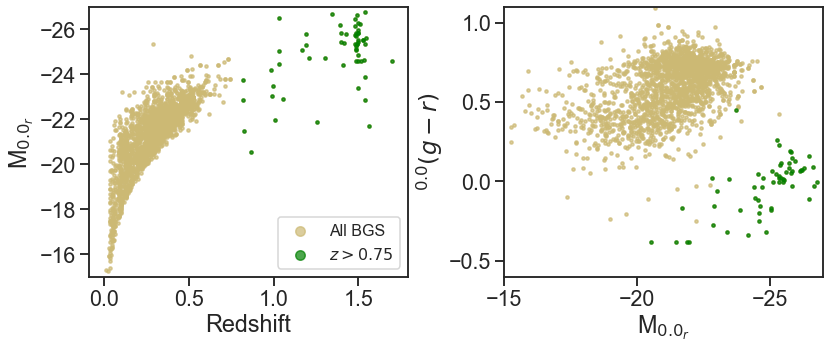

In [19]:
restphot(targ='BGS_ANY', png=os.path.join(figdir, 'bgs-restphot.png'))    

2005 1285 0.6408977556109726
Writing /Users/ioannis/research/talks/20210106-desitarget/bgs-d4000-halpha.png


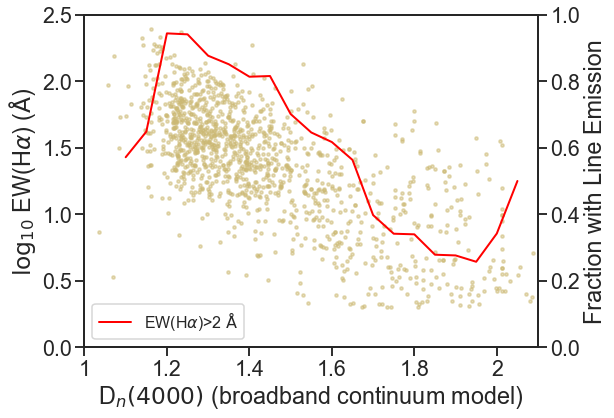

In [20]:
def d4000hist_bins(deltad4000=0.05, d4000min=1.1, d4000max=2.2, binedges=False):
    if binedges:
        bins = np.arange(d4000min, d4000max, deltad4000) # bin left edges
    else:
        bins = np.arange(d4000min, d4000max, deltad4000) + deltad4000 / 2 # bin centers
    return bins

def d4000hist_type(data, target='ELG'):
    bins = d4000hist_bins(binedges=True)
    hist, _ = np.histogram(data, bins=len(bins), range=(bins.min(), bins.max()))
    return hist, bins

def d4000(targ='BGS_ANY', png=None):

    itarg = np.where((spec['SV1_DESI_TARGET'] & desi_mask.mask(targ) != 0))[0]
    itarg_halpha = np.where((spec['SV1_DESI_TARGET'] & desi_mask.mask(targ) != 0) * 
                            (spec['HALPHA_EW'] > 2) *
                            (spec['Z'] < 0.45))[0]
    print(len(itarg), len(itarg_halpha), len(itarg_halpha)/len(itarg))

    fig, ax = plt.subplots(figsize=(9, 6))
    ax.scatter(phot['D4000_MODEL_PHOT'][itarg_halpha], np.log10(spec['HALPHA_EW'][itarg_halpha]), 
               s=10, marker=pref[targ]['marker'], alpha=0.5, label=targ,
               color=pref[targ]['color'])
    #ax.set_xscale('log')
    ax.set_xlim(1, 2.1)
    ax.set_ylim(0, 2.5)
    ax.set_xlabel(r'D$_{n}(4000)$ (broadband continuum model)')
    ax.set_ylabel(r'$\log_{10}$ EW(H$\alpha$) ($\mathrm{\AA}$)')
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    #ax.legend(loc='lower left', markerscale=3, fontsize=18)    

    d4000hist, d4000bins = d4000hist_type(phot['D4000_MODEL_PHOT'][itarg])
    d4000hist_halpha, _ = d4000hist_type(phot['D4000_MODEL_PHOT'][itarg_halpha])
    #print(d4000hist, d4000hist_halpha)
    #print(np.sum(d4000hist), np.sum(d4000hist_halpha))
    
    good = np.where((d4000hist > 0) * (d4000hist_halpha > 5))[0]
        
    axtwin = ax.twinx()
    axtwin.plot(d4000bins[good], d4000hist_halpha[good]/d4000hist[good], 
                color='red', ls='-', lw=2, label=r'EW(H$\alpha$)>2 $\mathrm{\AA}$')
    axtwin.set_ylim(0, 1)
    axtwin.set_ylabel(r'Fraction with Line Emission')
    axtwin.legend(loc='lower left', fontsize=16)
    
    fig.subplots_adjust(left=0.16, bottom=0.17, right=0.86, top=0.94)
    
    if png:
        print('Writing {}'.format(png))
        fig.savefig(png)
        
d4000('BGS_ANY', png=os.path.join(figdir, 'bgs-d4000-halpha.png'))

### Spectral stacks

In [48]:
stackfile = os.path.join(figdir, 'rest-elgs-80608.fits')
wave = fitsio.read(stackfile, 'WAVE')
flux = fitsio.read(stackfile, 'FLUX')

In [58]:
from astropy.stats import sigma_clipped_stats
mn, md, sig = sigma_clipped_stats(flux, sigma=3, axis=0)

In [59]:
mn

array([ 0.00000000e+00,  4.18065530e-05,  2.68051102e-05, ...,
        0.00000000e+00,  0.00000000e+00, -3.84990554e-06])

(3712, 3742)

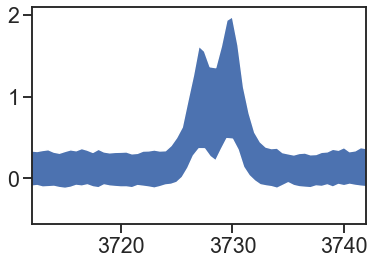

In [56]:
plt.fill_between(wave, mn-sig, mn+sig)
plt.xlim(3727 + np.array([-15, 15]))
#plt.ylim(-2, 10)

In [ ]:
stop

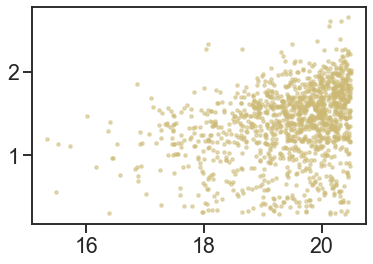

In [21]:
def doit(targ='BGS_ANY'):
    itarg_halpha = np.where((spec['SV1_DESI_TARGET'] & desi_mask.mask(targ) != 0) * 
                            (spec['HALPHA_EW'] > 2) *
                            (spec['Z'] < 0.45))[0]
    plt.scatter(22.5-2.5*np.log10(phot['FLUX_R'][itarg_halpha]), 
                np.log10(spec['HALPHA_EW'][itarg_halpha]), 
                s=10, marker=pref[targ]['marker'], alpha=0.5, label=targ,
                color=pref[targ]['color'])
doit()